c:\Users\marya\anaconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


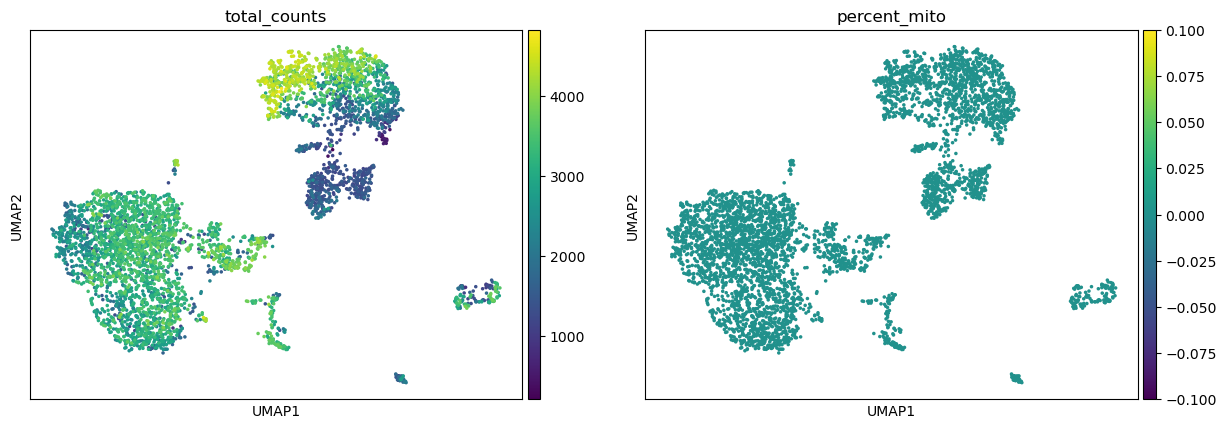

In [1]:
import scanpy as sc
from pathlib import Path

# Load the data
file_path = Path("C:/Users/marya/single-cell-project/Single-Cell-Transcriptomics/def0f5d7-cf3f-41b5-becf-888d1d54938d.h5ad")
adata = sc.read(file_path)

# Compute total counts per cell (sum of counts per cell)
# Sum across genes (axis=1), and flatten to get a 1D array of shape (n_cells,)
adata.obs['total_counts'] = adata.X.sum(axis=1).A1  # A1 flattens the sparse matrix

# Identify mitochondrial genes (assuming they start with 'MT-')
mito_genes = [gene for gene in adata.var_names if gene.startswith('MT-')]

# Sum the expression of mitochondrial genes for each cell
mito_expression = adata[:, mito_genes].X.sum(axis=1).A1  # Sum mitochondrial genes and flatten

# Calculate the percentage of mitochondrial expression
adata.obs['percent_mito'] = (mito_expression / adata.obs['total_counts']) * 100

# Perform quality control by filtering cells and genes
sc.pp.filter_cells(adata, min_counts=200)
sc.pp.filter_genes(adata, min_cells=3)

# Identify highly variable genes
sc.pp.highly_variable_genes(adata, n_top_genes=min(2000, adata.shape[1]))

# Perform PCA (Principal Component Analysis)
sc.tl.pca(adata, n_comps=50)

# Compute nearest neighbors based on PCA
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

# Compute UMAP (Uniform Manifold Approximation and Projection)
sc.tl.umap(adata)

# Plot UMAP colored by total counts and percentage of mitochondrial genes
sc.pl.umap(adata, color=["total_counts", "percent_mito"])

0.8.2
Index(['orig.ident', 'nCount_RNA', 'nFeature_RNA', 'seurat_clusters', 'mtFrac',
       'age', 'CnT', 'DTLH', 'UBCD', 'SSBpr', 'End', 'MSC', 'RVCSB', 'SSBpod',
       'SSBm.d', 'ICa', 'ErPrT', 'ICb', 'NPC', 'Pod', 'author_cell_type',
       'cell_type_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id',
       'development_stage_ontology_term_id', 'tissue_ontology_term_id',
       'sex_ontology_term_id', 'organism_ontology_term_id', 'is_primary_data',
       'assay_ontology_term_id', 'donor_id', 'suspension_type', 'tissue_type',
       'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'observation_joinid',
       'total_counts', 'percent_mito', 'n_counts', 'louvain'],
      dtype='object')


c:\Users\marya\anaconda3\envs\myenv\lib\site-packages\scanpy\tools\_rank_genes_groups.py:458: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


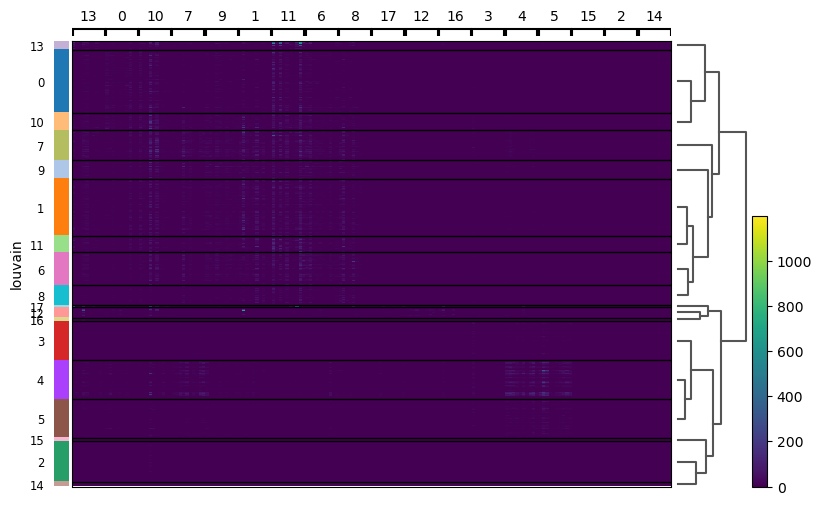

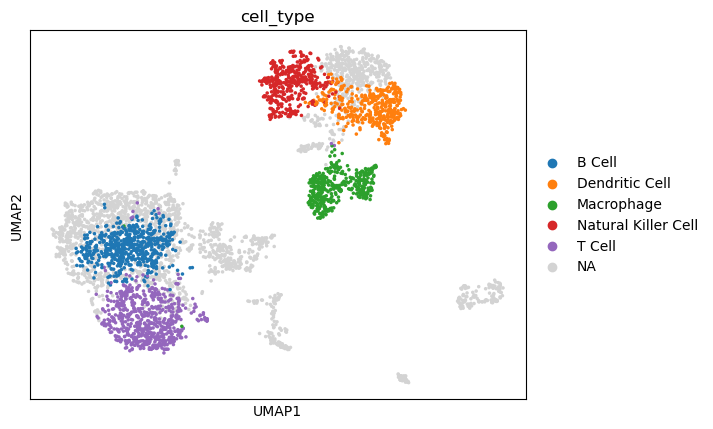

In [2]:
import scanpy as sc
import louvain
print(louvain.__version__)

# Step 1: Compute nearest neighbors based on PCA (already done in previous workshops)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_pca')

# Step 2: Perform Louvain clustering
sc.tl.louvain(adata, resolution=1.0)

# Ensure the Louvain clustering result is present in adata.obs
print(adata.obs.keys())  # Check if 'louvain' column exists now

# Step 3: Rank genes to identify marker genes for each cluster
sc.tl.rank_genes_groups(adata, groupby='louvain', method='t-test')

# Step 4: Visualize marker genes using a heatmap
sc.pl.rank_genes_groups_heatmap(adata, n_genes=10, groupby='louvain')

# Step 5: Annotate clusters manually based on known markers
cluster_annotations = {
    '0': 'T Cell',
    '1': 'B Cell',
    '2': 'Macrophage',
    '3': 'Dendritic Cell',
    '4': 'Natural Killer Cell'
}

# Add annotations to the 'louvain' cluster column
adata.obs['cell_type'] = adata.obs['louvain'].map(cluster_annotations).copy()

# Step 6: Visualize UMAP with annotated cell types
sc.pl.umap(adata, color='cell_type')
